# Defect Classifications of AOI

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm import tqdm

In [71]:
EPOCHS = 100

## Get file and score

In [120]:
def Drawloss(loss_list, val_loss_list):
    lens = len(loss_list)
    fig = plt.figure(figsize=(8, 5))
    fig.add_subplot(2,2,(1,4))
    plt.style.use("ggplot")

    plt.plot(range(1, lens+1), loss_list, label="train_loss")
    plt.plot(range(1, lens+1), val_loss_list, label="val_loss")

    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    plt.show()

In [114]:
def val_accuracy(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type == 'cuda':
        model = torch.load(model_path)
    else:
        model = torch.load(model_path, map_location=torch.device('cpu'))
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f"{model_path}, Val Accuracy: {accuracy:.2f}%")

In [115]:
def test_result(model_path, csv_filename):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type == 'cuda':
        model = torch.load(model_path)
    else:
        model = torch.load(model_path, map_location=torch.device('cpu'))
    model.eval()
    correct = 0
    total = 0
    predicted_list = []
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted_list.append(predicted.item())
            
    test_df['Label'] = predicted_list
    test_df.to_csv(f'{csv_filename}', index=False)

## 1. Data preprocess

In [83]:
train_df = pd.read_csv('/kaggle/input/csv-index/train.csv')

In [84]:
len(train_df)

2528

In [76]:
class CustomDataset(Dataset):
    def __init__(self, csv_path, images_folder, transform = False):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = self.df.loc[index, "ID"]
        label = self.df.loc[index, "Label"].item()
        image = Image.open(os.path.join(self.images_folder, filename))
        if self.transform:
            image = self.transform(image)
        return image, label

In [85]:
transform = transforms.Compose([
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.ToTensor()
])

In [91]:
dataset = CustomDataset('/kaggle/input/csv-index/train.csv','/kaggle/input/train-image-aoi/train_images', transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.9, 0.1])
test_dataset = CustomDataset('/kaggle/input/csv-index/test.csv','/kaggle/input/test-image-aoi/test_images', transform=test_transform)

val_dataloader = DataLoader(validate_dataset, batch_size=32, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [106]:
for images, labels in train_dataloader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 1, 512, 512])
torch.Size([32])


In [107]:
class EarlyStopper:
    def __init__(self, model_path, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.model_path = model_path
        self.counter = 0
        self.min_val_loss = np.inf

    def check(self, val_loss, model):
        if val_loss < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0
            torch.save(model, self.model_path)
        elif val_loss > (self.min_val_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False 

## 2. PSPNet Model
> current best 0.9561
- extract feature based on Conv
- Use Pyramid Pooling, Onebyone Conv
- Append Upsampling
- Conv + Linear to classify
- all from scratch

In [108]:
model_path = f'/kaggle/working/PSPNet_epoch{EPOCHS}_kaggle.pt'
predict_csv_path = f'/kaggle/working/PSPNet_epoch{EPOCHS}_kaggle.csv'

In [109]:
class PSPNet(nn.Module):
    def __init__(self, num_classes):
        super(PSPNet, self).__init__()
        
        # Conv layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1), # output size (N, 16, 512, 512)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 16, 256, 256)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1), # output size (N, 32, 256, 256)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 32, 128, 128)
        )
        # Spatial Pyramid Pooling layers
        self.pool1 = nn.AdaptiveMaxPool2d((1, 1)) # output size (N, 32, 1, 1)
        self.pool2 = nn.AdaptiveMaxPool2d((2, 2)) # output size (N, 32, 2, 2)
        self.pool3 = nn.AdaptiveMaxPool2d((3, 3)) # output size (N, 32, 3, 3)
        self.pool4 = nn.AdaptiveMaxPool2d((6, 6)) # output size (N, 32, 6, 6)
        self.con1 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 1, 1)
        self.con2 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 2, 2)
        self.con3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 3, 3)
        self.con4 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 6, 6)
        # Upsampling layers
        self.upsample1 = nn.Upsample(scale_factor=128/1, mode='bilinear', align_corners=True) # output size (N, 1, 128, 128)
        self.upsample2 = nn.Upsample(scale_factor=128/2, mode='bilinear', align_corners=True) # output size (N, 1, 128, 128)
        self.upsample3 = nn.Upsample(scale_factor=128/3, mode='bilinear', align_corners=True) # output size (N, 1, 128, 128)
        self.upsample4 = nn.Upsample(scale_factor=128/6, mode='bilinear', align_corners=True) # output size (N, 1, 128, 128)
        # Conv Classifier layers
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=36, out_channels=18, kernel_size=3, stride=2, padding=1), # output size (N, 18, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 18, 32, 32)
            nn.Conv2d(in_channels=18, out_channels=9, kernel_size=3, stride=2, padding=1), # output size (N, 9, 16, 16)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 9, 8, 8)
            nn.Flatten(), # output size (N, 9 * 8 * 8)
            nn.Linear(9 * 8 * 8, 128), # output size (N, 128)
            nn.ReLU(),
            nn.Linear(128, num_classes), # output size (N, 6)
        )
        
    def forward(self, x):
        # CNN layers
        x = self.features(x)
        
        # Spatial Pyramid Pooling
        x1 = self.pool1(x)
        x1 = self.con1(x1) 
        x2 = self.pool2(x)
        x2 = self.con2(x2)
        x3 = self.pool3(x)
        x3 = self.con3(x3)
        x4 = self.pool4(x)
        x4 = self.con4(x4)
        
        # Upsampling
        x1 = self.upsample1(x1)
        x2 = self.upsample2(x2)
        x3 = self.upsample3(x3)
        x4 = self.upsample4(x4)
        
        # Concatenate the pooled features
        x = torch.cat((x1, x2, x3, x4, x), dim=1) # output size (N, 36, 128, 128)
        
        # Classifier
        x = self.classifier(x)
        return x

In [110]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TextureCNN(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_list = []
val_loss_list = []
early_stopper = EarlyStopper(model_path = model_path)

for epoch in range(EPOCHS):
    model.train()
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        tmp_loss_list = []
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            tmp_loss_list.append(val_loss.item())
        avg_val_loss = sum(tmp_loss_list)/len(tmp_loss_list)
        val_loss_list.append(avg_val_loss)
        if early_stopper.check(avg_val_loss, model):
            print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f},\nEarly stop in {epoch+1}!!')
            break
            
    if (epoch+1) % 1 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f}')

Epoch [1/100], Train Loss: 1.5690, Val Loss:1.3764
Epoch [2/100], Train Loss: 0.9684, Val Loss:0.9037
Epoch [3/100], Train Loss: 0.3819, Val Loss:0.4223
Epoch [4/100], Train Loss: 0.1057, Val Loss:0.9175
Epoch [5/100], Train Loss: 0.4749, Val Loss:0.5645
Epoch [6/100], Train Loss: 0.0316, Val Loss:0.2968
Epoch [7/100], Train Loss: 0.1370, Val Loss:0.2507
Epoch [8/100], Train Loss: 0.2337, Val Loss:0.2727
Epoch [9/100], Train Loss: 0.4622, Val Loss:0.3333
Epoch [10/100], Train Loss: 0.4225, Val Loss:0.0409
Epoch [11/100], Train Loss: 0.0280, Val Loss:0.0236
Epoch [12/100], Train Loss: 0.0432, Val Loss:0.2580
Epoch [13/100], Train Loss: 0.1408, Val Loss:0.2935
Epoch [14/100], Train Loss: 0.0311, Val Loss:0.0375
Epoch [15/100], Train Loss: 0.0018, Val Loss:0.0557
Epoch [16/100], Train Loss: 0.0064, Val Loss:0.0519
Epoch [17/100], Train Loss: 0.0299, Val Loss:0.4301
Epoch [18/100], Train Loss: 0.4971, Val Loss:0.6700
Epoch [19/100], Train Loss: 0.0562, Val Loss:0.6914
Epoch [20/100], Train

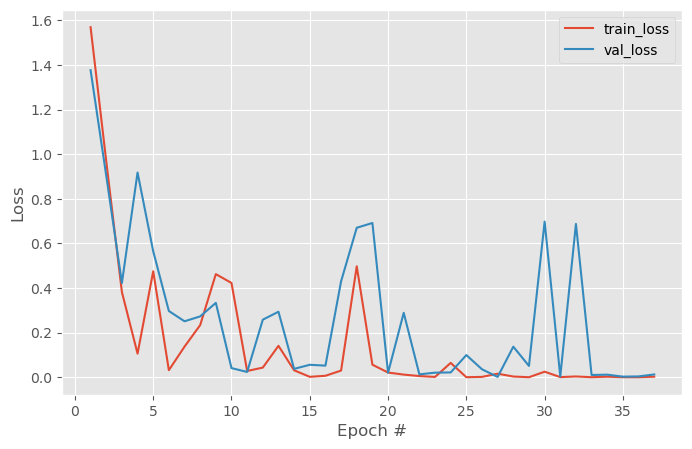

In [111]:
Drawloss(loss_list, val_loss_list)

In [116]:
# torch.save(model, model_path)
val_accuracy(model_path)
test_result(model_path, predict_csv_path)

100%|██████████| 8/8 [00:01<00:00,  5.44it/s]


/kaggle/working/TextureCNN_epoch100_kaggle.pt, Val Accuracy: 97.22%


100%|██████████| 10142/10142 [02:58<00:00, 56.82it/s]


## 3. Baseline
> second best, In feature layer, channels number half is better. Half score(16->32):0.9528976,Full score(32->64):0.9418002
- extract feature based on Conv
- Linear to classify
- all from scratch

In [133]:
model_path = f'/kaggle/working/Base_epoch{EPOCHS}_kaggle.pt'
predict_csv_path = f'/kaggle/working/Base_epoch{EPOCHS}_kaggle.csv'

In [134]:
class BasicCNN(nn.Module):
    def __init__(self, num_classes):
        super(BasicCNN, self).__init__()
        
        # Conv layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1), # output size (N, 16, 512, 512)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 32, 256, 256)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1), # output size (N, 32, 256, 256)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 32, 128, 128)
        )
        # Conv Classifier layers
        self.classifier = nn.Sequential(
            nn.Flatten(), # output size (N, 32 * 128 * 128)
            nn.Linear(32 * 128 * 128, 128), # output size (N, 128)
            nn.ReLU(),
            nn.Linear(128, num_classes), # output size (N, 6)
        )
        
    def forward(self, x):
        # CNN layers
        x = self.features(x)
        x = self.classifier(x)
        return x

In [137]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BasicCNN(num_classes=6).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_list = []
val_loss_list = []
early_stopper = EarlyStopper(model_path = model_path)

for epoch in range(EPOCHS):
    model.train()
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        tmp_loss_list = []
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            tmp_loss_list.append(val_loss.item())
        avg_val_loss = sum(tmp_loss_list)/len(tmp_loss_list)
        val_loss_list.append(avg_val_loss)
        if early_stopper.check(avg_val_loss, model):
            print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f},\nEarly stop in {epoch+1}!!')
            break
            
    if (epoch+1) % 1 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f}')

Epoch [1/100], Train Loss: 2.1219, Val Loss:1.6476
Epoch [2/100], Train Loss: 1.0200, Val Loss:1.0471
Epoch [3/100], Train Loss: 0.6770, Val Loss:0.8454
Epoch [4/100], Train Loss: 0.2833, Val Loss:0.8128
Epoch [5/100], Train Loss: 0.5021, Val Loss:0.6166
Epoch [6/100], Train Loss: 1.1920, Val Loss:0.3445
Epoch [7/100], Train Loss: 0.0897, Val Loss:0.2718
Epoch [8/100], Train Loss: 0.2475, Val Loss:0.2145
Epoch [9/100], Train Loss: 0.0264, Val Loss:0.1979
Epoch [10/100], Train Loss: 0.0968, Val Loss:0.2802
Epoch [11/100], Train Loss: 0.0333, Val Loss:0.1345
Epoch [12/100], Train Loss: 0.0118, Val Loss:0.1174
Epoch [13/100], Train Loss: 0.1921, Val Loss:0.1334
Epoch [14/100], Train Loss: 0.0052, Val Loss:0.0924
Epoch [15/100], Train Loss: 0.0460, Val Loss:0.1191
Epoch [16/100], Train Loss: 0.0000, Val Loss:0.0942
Epoch [17/100], Train Loss: 0.0518, Val Loss:0.0976
Epoch [18/100], Train Loss: 0.0032, Val Loss:0.1915
Epoch [19/100], Train Loss: 0.0015, Val Loss:0.0896
Epoch [20/100], Train

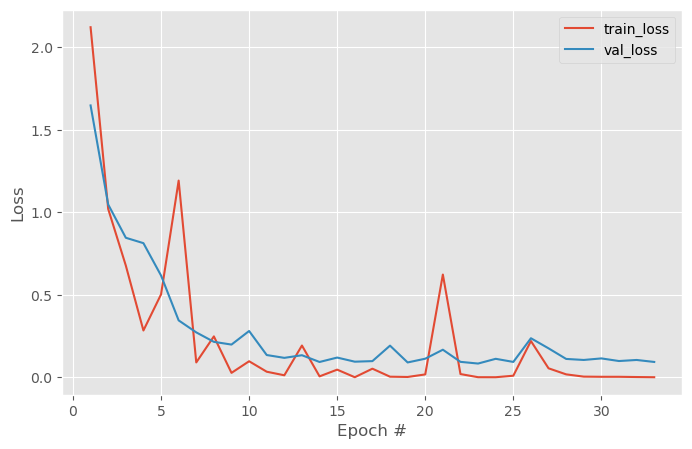

100%|██████████| 8/8 [00:01<00:00,  5.37it/s]


/kaggle/working/Base_epoch100_kaggle.pt, Val Accuracy: 98.81%


100%|██████████| 10142/10142 [01:08<00:00, 147.10it/s]


In [138]:
Drawloss(loss_list, val_loss_list)
val_accuracy(model_path)
test_result(model_path, predict_csv_path)

## 4. ResNet 18
> The worst no need to submit
- first layer 3 channels change to 1 channel
- last append a new linear 
    - input size 1000 
    - output size class_num=6
- only train above 2 layers, other layer use pretrained ResNet18

In [128]:
# # 檢視 ResNet18 模型結構
# net = models.resnet18()
# print(net)

In [129]:
model_path = f'/kaggle/working/ResNet18_epoch{EPOCHS}_kaggle.pt'
predict_csv_path = f'/kaggle/working/ResNet18_epoch{EPOCHS}_kaggle.pt'

In [130]:
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        
        # Modify the first layer to accept single-channel input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Freeze the layers except the new conv1 and the classification layer
        for name, param in self.resnet.named_parameters():
            if 'conv1' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        
        # Modify the classification layer
        self.classifier = nn.Linear(self.resnet.fc.out_features, num_classes)
        
    def forward(self, x):
        x = self.resnet(x)
        x = self.classifier(x)
        return x

In [131]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the model
num_classes = 6
model = ResNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# Define the optimizer for fine-tuning using Adam with a single learning rate
fine_tune_params = list(model.resnet.conv1.parameters()) + list(model.classifier.parameters())
optimizer = torch.optim.Adam(fine_tune_params, lr=0.001, betas=(0.9, 0.999))

loss_list = []
val_loss_list = []
early_stopper = EarlyStopper(model_path = model_path)

for epoch in range(EPOCHS):
    model.train()
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        tmp_loss_list = []
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            tmp_loss_list.append(val_loss.item())
        avg_val_loss = sum(tmp_loss_list)/len(tmp_loss_list)
        val_loss_list.append(avg_val_loss)
        if early_stopper.check(avg_val_loss, model):
            print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f},\nEarly stop in {epoch+1}!!')
            break
            
    if (epoch+1) % 1 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f}')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100], Train Loss: 1.1159, Val Loss:1.6740
Epoch [2/100], Train Loss: 2.2667, Val Loss:2.7956
Epoch [3/100], Train Loss: 1.1289, Val Loss:1.2379
Epoch [4/100], Train Loss: 0.9062, Val Loss:0.8075
Epoch [5/100], Train Loss: 0.2080, Val Loss:0.7813
Epoch [6/100], Train Loss: 0.0084, Val Loss:2.5921
Epoch [7/100], Train Loss: 0.2080, Val Loss:2.7423
Epoch [8/100], Train Loss: 0.0336, Val Loss:3.4079
Epoch [9/100], Train Loss: 2.0232, Val Loss:1.6156
Epoch [10/100], Train Loss: 0.0729, Val Loss:0.4063
Epoch [11/100], Train Loss: 1.7058, Val Loss:3.1305
Epoch [12/100], Train Loss: 0.3574, Val Loss:0.7805
Epoch [13/100], Train Loss: 0.1662, Val Loss:0.5514
Epoch [14/100], Train Loss: 0.2310, Val Loss:1.2254
Epoch [15/100], Train Loss: 1.6394, Val Loss:0.4862
Epoch [16/100], Train Loss: 1.7020, Val Loss:4.4779
Epoch [17/100], Train Loss: 0.0730, Val Loss:2.2311
Epoch [18/100], Train Loss: 0.1184, Val Loss:3.4166
Epoch [19/100], Train Loss: 0.0085, Val Loss:1.2620
Epoch [20/100], Train

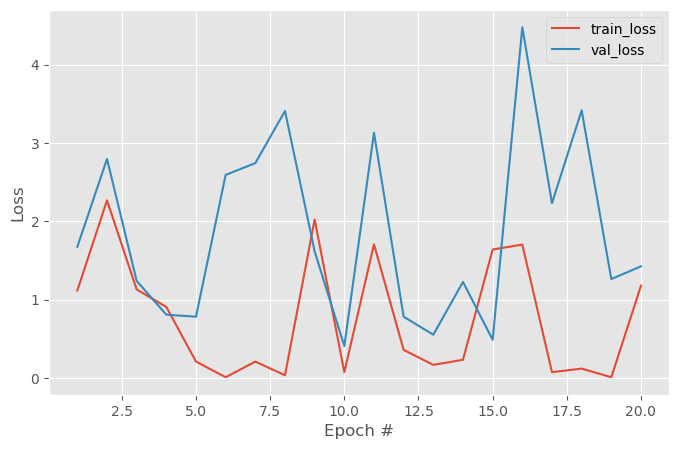

100%|██████████| 8/8 [00:01<00:00,  4.58it/s]


/kaggle/working/ResNet18_epoch100_kaggle.pt, Val Accuracy: 75.40%


100%|██████████| 10142/10142 [01:22<00:00, 123.63it/s]


In [132]:
Drawloss(loss_list, val_loss_list)
val_accuracy(model_path)
test_result(model_path, predict_csv_path)

## 5. ResNet18 with PSPNet idea
> score: 0.9420468, worse then all from scratch
- first layer 3 channels change to 1 channel
- last append Pyramid Pooling layers, Onebyone Conv and Upsampling before ResNet18 layer4
- Conv + Linear to classify
- Train above 3 layers, other layer use pretrained ResNet18

In [117]:
model_path = f'/kaggle/working/ResNetPSPNet_epoch{EPOCHS}_kaggle.pt'
predict_csv_path = f'/kaggle/working/ResNetPSPNet_epoch{EPOCHS}_kaggle.csv'

In [118]:
class ResNetPSPNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNetPSPNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        
        # Modify the first layer to accept single-channel input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Freeze the layers except the new conv1 and the classification layer
        for name, param in self.resnet.named_parameters():
            if 'conv1' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        
        # Spatial Pyramid Pooling layers
        self.pool1 = nn.AdaptiveMaxPool2d((1, 1)) # output size (N, 512, 1, 1)
        self.pool2 = nn.AdaptiveMaxPool2d((2, 2)) # output size (N, 512, 2, 2)
        self.pool3 = nn.AdaptiveMaxPool2d((3, 3)) # output size (N, 512, 3, 3)
        self.pool4 = nn.AdaptiveMaxPool2d((6, 6)) # output size (N, 512, 6, 6)
        self.onebyonecon1 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 1, 1)
        self.onebyonecon2 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 2, 2)
        self.onebyonecon3 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 3, 3)
        self.onebyonecon4 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 6, 6)
        # Upsampling layers
        self.upsample1 = nn.Upsample(scale_factor=16/1, mode='bilinear', align_corners=True) # output size (N, 1, 16, 16)
        self.upsample2 = nn.Upsample(scale_factor=16/2, mode='bilinear', align_corners=True) # output size (N, 1, 16, 16)
        self.upsample3 = nn.Upsample(scale_factor=16/3, mode='bilinear', align_corners=True) # output size (N, 1, 16, 16)
        self.upsample4 = nn.Upsample(scale_factor=16/6, mode='bilinear', align_corners=True) # output size (N, 1, 16, 16)
        # Conv Classifier layers
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=516, out_channels=128, kernel_size=3, stride=2, padding=1), # output size (N, 128, 8, 8)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 128, 4, 4)
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1), # output size (N, 64, 2, 2)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 64, 1, 1)
            nn.Flatten(), # output size (N, 64 * 1 * 1)
            nn.Linear(64, num_classes), # output size (N, 6)
        )
        
    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        
        # Spatial Pyramid Pooling
        x1 = self.pool1(x)
        x1 = self.onebyonecon1(x1) 
        x2 = self.pool2(x)
        x2 = self.onebyonecon2(x2)
        x3 = self.pool3(x)
        x3 = self.onebyonecon3(x3)
        x4 = self.pool4(x)
        x4 = self.onebyonecon4(x4)
        
        # Upsampling
        x1 = self.upsample1(x1)
        x2 = self.upsample2(x2)
        x3 = self.upsample3(x3)
        x4 = self.upsample4(x4)
        
        # Concatenate the pooled features
        x = torch.cat((x1, x2, x3, x4, x), dim=1) # output size (N, 516, 16, 16)
        
        # Classifier
        x = self.classifier(x)
        
        return x

In [119]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the model
num_classes = 6
model = ResNetPSPNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
# Define the optimizer for fine-tuning using Adam with a single learning rate

# Create a list of parameters to optimize (conv1 and classifier)
parameters_to_optimize = [
    {'params': model.resnet.conv1.parameters()},
    {'params': model.onebyonecon1.parameters()},
    {'params': model.onebyonecon2.parameters()},
    {'params': model.onebyonecon3.parameters()},
    {'params': model.onebyonecon4.parameters()},
    {'params': model.classifier.parameters()},
]
optimizer = torch.optim.Adam(parameters_to_optimize, lr=0.001, betas=(0.9, 0.999))

loss_list = []
val_loss_list = []
early_stopper = EarlyStopper(model_path = model_path)

for epoch in range(EPOCHS):
    model.train()
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    
    
    model.eval()
    with torch.no_grad():
        tmp_loss_list = []
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            tmp_loss_list.append(val_loss.item())
        avg_val_loss = sum(tmp_loss_list)/len(tmp_loss_list)
        val_loss_list.append(avg_val_loss)
        if early_stopper.check(avg_val_loss, model):
            print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f},\nEarly stop in {epoch+1}!!')
            break
            
    if (epoch+1) % 1 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f}')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100], Train Loss: 1.8658, Val Loss:0.7423
Epoch [2/100], Train Loss: 0.2570, Val Loss:0.8721
Epoch [3/100], Train Loss: 0.0166, Val Loss:1.0572
Epoch [4/100], Train Loss: 0.3031, Val Loss:1.7196
Epoch [5/100], Train Loss: 0.0190, Val Loss:0.7276
Epoch [6/100], Train Loss: 0.1717, Val Loss:0.4929
Epoch [7/100], Train Loss: 0.0249, Val Loss:1.0087
Epoch [8/100], Train Loss: 0.1347, Val Loss:1.0424
Epoch [9/100], Train Loss: 0.7873, Val Loss:0.5037
Epoch [10/100], Train Loss: 0.0625, Val Loss:2.6925
Epoch [11/100], Train Loss: 0.0301, Val Loss:1.0010
Epoch [12/100], Train Loss: 0.0044, Val Loss:0.6199
Epoch [13/100], Train Loss: 0.5694, Val Loss:2.0702
Epoch [14/100], Train Loss: 0.0012, Val Loss:0.4217
Epoch [15/100], Train Loss: 0.0022, Val Loss:0.4952
Epoch [16/100], Train Loss: 0.5061, Val Loss:0.6387
Epoch [17/100], Train Loss: 0.0033, Val Loss:0.3842
Epoch [18/100], Train Loss: 0.0024, Val Loss:0.6222
Epoch [19/100], Train Loss: 0.0917, Val Loss:0.0698
Epoch [20/100], Train

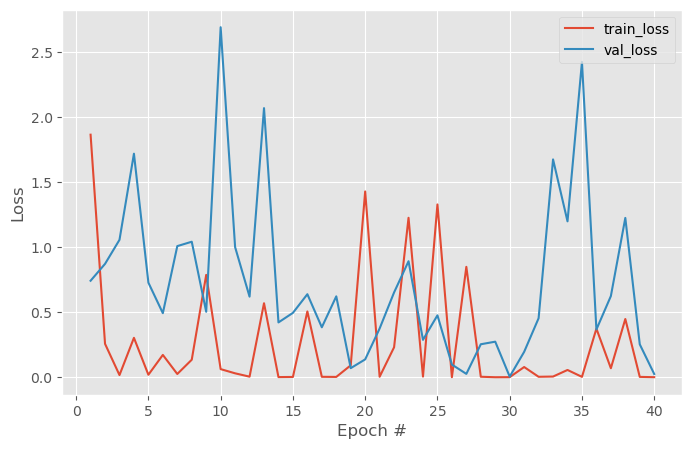

In [122]:
Drawloss(loss_list, val_loss_list)

In [123]:
val_accuracy(model_path)
test_result(model_path, predict_csv_path)

100%|██████████| 8/8 [00:01<00:00,  4.12it/s]


/kaggle/working/ResNetPSPNet_epoch100_kaggle.pt, Val Accuracy: 97.22%


100%|██████████| 10142/10142 [01:30<00:00, 112.19it/s]
